In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup as bs
import time
import re
from urllib.request import urlopen
import json
from pandas.io.json import json_normalize
import pandas as pd, numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

#driver = webdriver.Chrome(ChromeDriverManager().install())

#https://medium.com/@mottet.dev/lets-create-an-instagram-bot-to-show-you-the-power-of-selenium-349d7a6744f7
class InstagramBot():
    def __init__(self, email, password):
        # new variable containing empty ChromeOptions
        self.browserProfile = webdriver.ChromeOptions()
        # always load the page in English
        self.browserProfile.add_experimental_option('prefs',{'intl.accept_languages':'en, en_US'})
        # include filepath of chrome drirver
       # self.browser = webdriver.Chrome('/cmps184/tutorial/chromedriver', chrome_options=self.browserProfile)
        self.browser =  webdriver.Chrome(ChromeDriverManager().install())
        self.email = email
        self.password = password

    def signIn(self):
        self.browser.get('https://www.instagram.com/accounts/login/')

        # select email and password inputs
        emailInput = self.browser.find_elements_by_css_selector('form input')[0]
        passwordInput = self.browser.find_elements_by_css_selector('form input')[1]

        # use .send_keys to complete form 
        emailInput.send_keys(self.email)
        passwordInput.send_keys(self.password)
        
        # send the form by clicking the ENTER key
        passwordInput.send_keys(Keys.ENTER)
        time.sleep(5)
        
        
    #---- Dealing With Pop-Up Notifications----
    # Added this code to disable notifications 
    def disableNotifications(self):
        offButton=self.browser.find_element_by_xpath("//button[@class='aOOlW   HoLwm ']")
        if offButton.text != "Not Now":
            print("Can't find button to turn off notifications")
        else:    
            print("Disabled Notifications")
            offButton.click()
            time.sleep(10)
            
    #---- Follow a User----
    # takes the username of the person we want to follow
    def followWithUsername(self, username):
        # go to user's page
        self.browser.get('https://www.instagram.com/' + username + '/')
        time.sleep(2)
        followButton = self.browser.find_element_by_css_selector('button')
        # check if we are already following the user
        if (followButton.text != 'Following'):
            followButton.click()
            time.sleep(5)
            print("----Followed {}----".format(username))
        else:
            print("----You are already following {}----".format(username))

    #---- Unfollow a User----
    def unfollowWithUsername(self, username):
        self.browser.get('https://www.instagram.com/' + username+'/')
        time.sleep(2)
        followButton = self.browser.find_element_by_css_selector('button')
        if(followButton.text == 'Following'):
            followButton.click()
            time.sleep(5)
            confirmButton=self.browser.find_element_by_xpath('//button[text() = "Unfollow"]')
            confirmButton.click()
            print("----Unfollowed {}----".format(username))
        else:
            print("----You are not following {}----".format(username))

    # two arguments: target's username, & number of followers we want
    def getUserFollowers(self, username, max):

        # navigate to user's profile page
        self.browser.get('https://www.instagram.com/'+ username)

        # locate "x followers" button
        followersLink = self.browser.find_element_by_css_selector('ul li a')

        # press button and a modal will open
        followersLink.click()
        time.sleep(5)

        # selects modal
        # <ul> points to general list of followers
        # select the <ul> inside a <div> with a "role" attribute = "dialog"
        # use backslash so Python doesn't think string ends there
        followersList = self.browser.find_element_by_css_selector('div[role=\'dialog\'] ul')

        # <li> is each follower row
        numberOfFollowersInList = len(followersList.find_elements_by_css_selector('li'))

        # this will "focus" on follower & allow us to use the
        # SPACE key to scroll down
        followersList.click()

        # actionChain will allow us to execute a list of actions
        # like (press a key, move mouse, etc) in a precise order
        actionChain = webdriver.ActionChains(self.browser)

        # as long as # of followers in list is lower than number
        # required, press SPACE
        # .perform() fires events in order they are queued
        while(numberOfFollowersInList < max):
            actionChain.key_down(Keys.SPACE).key_up(Keys.SPACE).perform()

            # refresh number of users we have in the list and print it
            numberOfFollowersInList = len(followersList.find_elements_by_css_selector('li'))
            #print("# of followers: ", numberOfFollowersInList)

        followers = []

        # loop through whole list of followers
        print("----- List of followers \n")
        for user in followersList.find_elements_by_css_selector('li'):
            # extract profile link
            userLink = user.find_element_by_css_selector('a').get_attribute('href')
            print(userLink)
            # append user to new list
            followers.append(userLink)

            # return new list once we've reached max
            if(len(followers) == max):
                break
        return 
    
    def getPictureData(self, username):
        self.browser.get('https://www.instagram.com/'+ username)
        imageList = []
        likeList = []
        imageTypeList = []
        vidList = []
        prevList = []
        accesList = []
        timeList = []
        taggedList = []
        captionList = []
        captionEditList = []
        commentsList = []
        locationList = []
        adList = []
        timeAdjust = []

        # Find image links
        images = self.browser.find_elements_by_css_selector('div[class=\'v1Nh3 kIKUG  _bz0w\'] a')

        # Append <href> image link to a list
        for image in images:
            imageLink = image.get_attribute('href')
            imageList.append(imageLink)
        
        # Go to each image link and extract JSON object
        for i in range(len(imageList)):
            # https://medium.com/@srujana.rao2/scraping-instagram-with-python-using-selenium-and-beautiful-soup-8b72c186a058
            html = urlopen(imageList[i])
            data = bs(html.read(), 'html.parser')
            body = data.find('body')
            script = body.find('script')
            raw = script.text.strip().replace('window._sharedData =', '').replace(';', '') 
            # load raw data into dict variable
            json_data = json.loads(raw)
            posts =json_data['entry_data']['PostPage'][0]['graphql']["shortcode_media"]
            #print(json.dumps(posts, indent=2))

            print(imageList[i])
            # Get type of image
            # Either GraphImage or GraphVideo or GraphSideCar
            isImage = posts["__typename"]
            if isImage == 'GraphImage':
                # Number of likes for the picture
                likes = posts["edge_media_preview_like"]["count"]
                print("likes:", likes)
                likeList.append(likes)
                
                # Get type of image
                # Either GraphImage or GraphVideo or GraphSideCar
                isImage = posts["__typename"]
                imageTypeList.append(isImage)
                
                # is it a video? True/False
                isVideo = posts["is_video"]
                vidList.append(isVideo)
                
                # Image preview link
                preview = posts["display_resources"][0]["src"]
                prevList.append(preview)
                
                # What is in the picture?
                accessibility = posts["accessibility_caption"]
                accesList.append(accessibility)
                
                # Timestamp
                times = posts['taken_at_timestamp']
                timestamp = dt.datetime.fromtimestamp(times).strftime('%m-%d-%Y %H:%M:%S')
                
                # correct time for readability
                # %a - day of week
                # %I - hour on 12 hour scale
                # %M - minutes
                # %p - am/pm
                hourList = dt.datetime.fromtimestamp(times).strftime('%a %I:%M %p')
                timeAdjust.append(hourList)
                timeList.append(timestamp)
                
                # Tagged users, what if multiple?
                tagged_username = posts["edge_media_to_tagged_user"]["edges"]
                
                # Check if there are no tagged users
                tagged_users = []
                if len(tagged_username) != 0:
                    for i in range(len(tagged_username)):
                        tagged_username = posts["edge_media_to_tagged_user"]["edges"][i]["node"]["user"]["username"]
                        tagged_users.append(tagged_username)
                else:
                    tagged_username = ""
                    tagged_users.append(tagged_username)
                taggedList.append(tagged_users)
                  
                # Caption
                caption = posts["edge_media_to_caption"]["edges"]
                
                # check if there is a caption
                if len(caption) != 0:
                    caption = caption[0]["node"]["text"]
                    captionList.append(caption)
                    
                    # what the caption edited?
                    caption_edit = posts["caption_is_edited"]
                    captionEditList.append(caption_edit)
                else:
                    caption = ""
                    captionList.append(caption)
                
               
                # Are comments diabled? True/False
                comment_disabled = posts["comments_disabled"]
                
                # Number of comments
                if comment_disabled is False:
                    try:
                        comments = posts['edge_media_preview_comment']['count']
                    except:
                        comments = posts['edge_media_to_comment']['count']
                commentsList.append(comments)
                
                # Is there a location? true/false
                locations = []
                isLocation = posts["location"]
                if isLocation is not None:
                    location_name = posts["location"]["name"]
                    locations.append(location_name)
                    
                else:
                    location_name = ""
                    locations.append(location_name)
                locationList.append(locations)
                
                # is this an Ad?
                isAd = posts["is_ad"]
                adList.append(isAd)
                
                
        # Create a dataframe  
        # create a dictionary with column labels
        d = {'likes count': likeList, 'post type': imageTypeList,
             'video': vidList,
             'image link': prevList, 'accessibility': accesList,
             'timestamp':timeList,'tagged accounts': taggedList,
             'caption': captionList,'caption Edit': captionEditList,
             'comment count': commentsList,'location':locationList,
             'advertisement': adList
            }
        
        df = pd.DataFrame(d)
        display(df)
    
    
        #----- Let's Plot Stuff----
        
        #time of day vs amount of likes
        fig2 = plt.figure(figsize=(10,8))
        ax = fig2.add_subplot(1,1,1)

        #assign colors
        colors = ['xkcd:greenish teal','xkcd:deep pink','xkcd:blueberry','xkcd:purple red','xkcd:periwinkle','xkcd:sky','xkcd:greyish pink']

        # Scatter Plot #1 for imdb x gross
        ax.plot(timeAdjust, likeList, c=colors[1], linewidth=2.0, marker='o')

        # set xlabels and ylabels and add padding between graph and labels
        ax.set_xlabel("Time", fontsize=16, labelpad=20)
        ax.set_ylabel("Count", fontsize=16, labelpad=20)
        
        #Rotate major tick labels by 30 degrees
        ax.tick_params(axis='x',rotation=30)
        plt.show()
    
    def closeBrowser(self):
        self.browser.close()

    def __exit__(self, exc_type, exc_value, traceback):
        self.closeBrowser()


Password :: ········

Checking for mac64 chromedriver:74.0.3729.6 in cache
Driver found in /Users/katelynsuhr/.wdm/chromedriver/74.0.3729.6/mac64/chromedriver
Disabled Notifications
----You are already following michiko_shiba----
----You are not following therock----
----- List of followers 

https://www.instagram.com/melbournevictoriaa/
https://www.instagram.com/savxella/
https://www.instagram.com/vy.brookey/
https://www.instagram.com/_.karima/
https://www.instagram.com/barbarakelly.furtuna/
https://www.instagram.com/julirandom97/
https://www.instagram.com/hokagefaith/
https://www.instagram.com/_kiaracaraballo_spam/
https://www.instagram.com/__ppl_cl_me_jay__/
https://www.instagram.com/chloequittenden/
https://www.instagram.com/screwthised/
https://www.instagram.com/adrijob/
https://www.instagram.com/fliplime5285588896/
https://www.instagram.com/moohamit/
https://www.instagram.com/heehoopeenut/
https://www.instagram.com/_noe111_/
https://www.instagram.com/_.abbycrum/
https://www.insta

likes count   post type  video  \
0       4657813  GraphImage  False   
1       2411739  GraphImage  False   
2       4389425  GraphImage  False   
3       2995597  GraphImage  False   
4       4427986  GraphImage  False   
5       5078260  GraphImage  False   
6       5450430  GraphImage  False   
7       3791302  GraphImage  False   
8       4069462  GraphImage  False   
9       4433371  GraphImage  False   
10      4772104  GraphImage  False   

                                           image link  \
0   https://scontent-lax3-1.cdninstagram.com/vp/9e...   
1   https://scontent-lax3-1.cdninstagram.com/vp/36...   
2   https://scontent-lax3-1.cdninstagram.com/vp/e9...   
3   https://scontent-lax3-1.cdninstagram.com/vp/e8...   
4   https://scontent-lax3-1.cdninstagram.com/vp/e6...   
5   https://scontent-lax3-1.cdninstagram.com/vp/8e...   
6   https://scontent-lax3-1.cdninstagram.com/vp/12...   
7   https://scontent-lax3-1.cdninstagram.com/vp/f3...   
8   https://scontent-lax3-1.cdninstagram.com/vp/72...   
9   https://scontent-lax3-1.cdninstagram.com/vp/6b...   
10  https://scontent-lax3-1.cdninstagram.com/vp/88...   

                                        accessibility            timestamp  \
0   Image may contain: one or more people and outdoor  06-02-2019 12:43:06   
1               Image may contain: one or more people  06-01-2019 13:11:43   
2   Image may contain: one or more people, people ...  06-01-2019 12:45:41   
3   Image may contain: one or more people, people ...  06-01-2019 00:03:25   
4   Image may contain: one or more people, shoes a...  05-30-2019 17:33:28   
5               Image may contain: one or more people  05-25-2019 11:46:55   
6   Image may contain: one or more people, people ...  05-18-2019 00:43:39   
7                   Image may contain: 1 person, text  05-09-2019 07:49:53   
8   Image may contain: one or more people and closeup  05-08-2019 19:04:16   
9   Image may contain: one or more people, sky, oc...  05-06-2019 17:15:22   
10       Image may contain: 1 person, shoes and night  05-01-2019 17:45:12   

                                      tagged accounts  \
0    [vandythepink, mattyvogel, koenigseggautomotive]   
1                               [finneas, mattyvogel]   
2                [finneas, mattyvogel, marshalldrums]   
3                                                  []   
4                                       [freakcityla]   
5                                                  []   
6                                [etai.la, slumpykev]   
7   [billboard, heatherhazzan, josephchase, robrum...   
8                                            [blohsh]   
9                                                  []   
10                            [finneas, jordankmunns]   

                        caption  caption Edit  comment count  \
0                      277.9mph         False          36913   
1                             🥺         False          17374   
2       last night was crazyyyy         False          26239   
3                           🥵🥵🥵         False          16565   
4   portland omw to you rnnnn➡️         False          33140   
5                          yeah         False          64302   
6                     huuuuuuuh         False          66639   
7                   “BILLBOARD”         False          29387   
8                             👕         False          31695   
9                             🚁          True          41244   
10                        BLISS          True          64209   

                             location  advertisement  
0       [Vancouver, British Columbia]          False  
1   [Moda Center at the Rose Quarter]          False  
2   [Moda Center at the Rose Quarter]          False  
3         [San Francisco, California]          False  
4             [Cupertino, California]          False  
5                     [Middlesbrough]          False  
6                                  []          False  
7                              

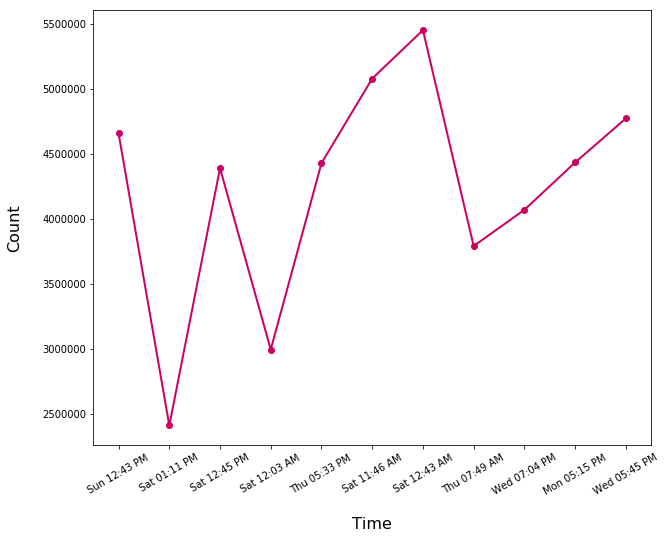

https://www.instagram.com/p/BxSgWiKF7Hc/
likes: 5208
https://www.instagram.com/p/Bvu7Kc1ldbp/
likes: 4575
https://www.instagram.com/p/BtUtq8flhS8/
likes: 4295
https://www.instagram.com/p/Br3vbsvF9US/
likes: 4114
https://www.instagram.com/p/Br3b59zljha/
likes: 3112
https://www.instagram.com/p/Br1SqDhlmWY/
likes: 3697
https://www.instagram.com/p/BrsriI_lenj/
likes: 4432
https://www.instagram.com/p/Brsqnf7lhRz/
likes: 2876
https://www.instagram.com/p/Brlzo6VFCnV/
likes: 3526
https://www.instagram.com/p/BrlxcfBFaaR/
likes: 2748
https://www.instagram.com/p/BrjFioxFuNC/
likes: 3590
https://www.instagram.com/p/BrjEFBplCJ_/
likes: 3123


likes count   post type  video  \
0          5208  GraphImage  False   
1          4575  GraphImage  False   
2          4295  GraphImage  False   
3          4114  GraphImage  False   
4          3112  GraphImage  False   
5          3697  GraphImage  False   
6          4432  GraphImage  False   
7          2876  GraphImage  False   
8          3526  GraphImage  False   
9          2748  GraphImage  False   
10         3590  GraphImage  False   
11         3123  GraphImage  False   

                                           image link  \
0   https://scontent-lax3-1.cdninstagram.com/vp/a8...   
1   https://scontent-lax3-1.cdninstagram.com/vp/3a...   
2   https://scontent-lax3-1.cdninstagram.com/vp/f8...   
3   https://scontent-lax3-1.cdninstagram.com/vp/0d...   
4   https://scontent-lax3-1.cdninstagram.com/vp/05...   
5   https://scontent-lax3-1.cdninstagram.com/vp/42...   
6   https://scontent-lax3-1.cdninstagram.com/vp/69...   
7   https://scontent-lax3-1.cdninstagram.com/vp/aa...   
8   https://scontent-lax3-1.cdninstagram.com/vp/54...   
9   https://scontent-lax3-1.cdninstagram.com/vp/ab...   
10  https://scontent-lax3-1.cdninstagram.com/vp/bc...   
11  https://scontent-lax3-1.cdninstagram.com/vp/03...   

                                        accessibility            timestamp  \
0         Image may contain: 1 person, dog and indoor  05-10-2019 09:43:35   
1                           Image may contain: indoor  04-01-2019 17:33:49   
2                           Image may contain: indoor  01-31-2019 19:12:52   
3   Image may contain: dog, christmas tree and indoor  12-26-2018 16:38:54   
4                  Image may contain: dog and outdoor  12-26-2018 13:48:16   
5    Image may contain: one or more people and indoor  12-25-2018 17:48:58   
6                              Image may contain: dog  12-22-2018 09:33:11   
7   Image may contain: ocean, dog, outdoor, nature...  12-22-2018 09:25:10   
8     Image may contain: dog, sky, outdoor and nature  12-19-2018 17:29:19   
9   Image may contain: ocean, water, outdoor and n...  12-19-2018 17:10:09   
10                  Image may contain: dog and indoor  12-18-2018 16:08:02   
11                  Image may contain: dog and indoor  12-18-2018 15:55:15   

   tagged accounts                                            caption  \
0               []                  Should I post more outfit photos?   
1               []  Henlo, I fit in bag so I can go into any store...   
2               []  Anyone hear today’s thunderstorms in LA? ⛈ the...   
3               []  I wished to be like a Christmas tree, so mama ...   
4               []                                  I wet , not ok 😣💦   
5               []  Merry Christmas everyone! I got a nice yummy y...   
6               []  Why hooman bring tree inside home? And why it ...   
7               []        Wao, I like fish. Fish tinks, but I like. 🎣   
8      [baby.navi]  My crazy hyper shibling turned 5 today! Seeing...   
9               []  If you go to my feed it looks like Eevee and I...   
10              []                                                😏😏😏   
11              []  Play hard, get dirty! I always shower here bec...   

    caption Edit  comment count            location  advertisement  
0          False             89                  []          False  
1          False             32                  []          False  
2          False             15                  []          False  
3          False             14                  []          False  
4           True              6                  []          False  
5          False              7                  []          False  
6          False             14                  []          False  
7          False              2                  []          False  
8          False             10                  []          False  
9           True              5                  []          False  
10         False              9            

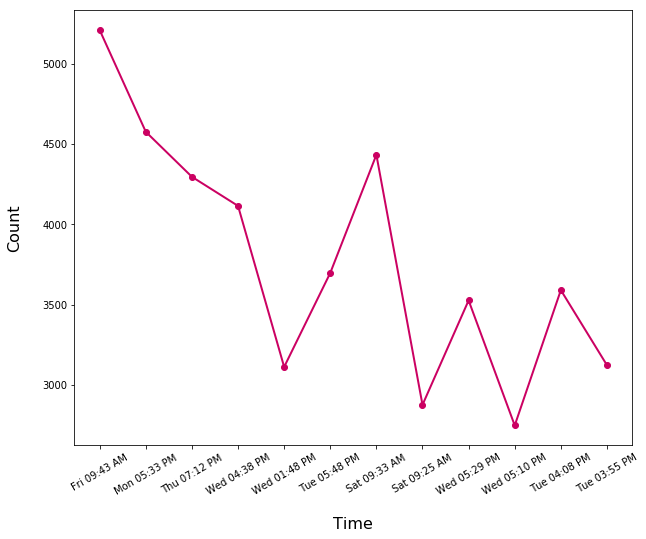

https://www.instagram.com/p/BySxDp0Fbat/
likes: 707665
https://www.instagram.com/p/ByRNdnrFoNZ/
https://www.instagram.com/p/ByQAaV7lW7s/
https://www.instagram.com/p/ByP_Fy_lsA1/
likes: 1323753
https://www.instagram.com/p/ByPFrDdFyQv/
https://www.instagram.com/p/ByPDkDNlLZv/
likes: 4456169
https://www.instagram.com/p/ByOYY3iljoV/
likes: 3897595
https://www.instagram.com/p/ByL9fJql9rB/
likes: 1790935
https://www.instagram.com/p/ByLkkZXldU_/
https://www.instagram.com/p/ByJwhp3lWXA/
likes: 1471107
https://www.instagram.com/p/ByHjNzIlSaT/
https://www.instagram.com/p/ByFnacyFmLY/


likes count   post type  video  \
0       707665  GraphImage  False   
1      1323753  GraphImage  False   
2      4456169  GraphImage  False   
3      3897595  GraphImage  False   
4      1790935  GraphImage  False   
5      1471107  GraphImage  False   

                                          image link  \
0  https://scontent-lax3-1.cdninstagram.com/vp/fc...   
1  https://scontent-lax3-1.cdninstagram.com/vp/ba...   
2  https://scontent-lax3-1.cdninstagram.com/vp/7d...   
3  https://scontent-lax3-1.cdninstagram.com/vp/6b...   
4  https://scontent-lax3-1.cdninstagram.com/vp/f6...   
5  https://scontent-lax3-1.cdninstagram.com/vp/fa...   

                                       accessibility            timestamp  \
0                            Image may contain: text  06-04-2019 08:40:57   
1                            Image may contain: food  06-03-2019 06:45:51   
2                            Image may contain: food  06-02-2019 22:05:42   
3                 Image may contain: car and outdoor  06-02-2019 15:48:26   
4  Image may contain: one or more people, people ...  06-01-2019 17:14:53   
5  Image may contain: one or more people and peop...  05-31-2019 20:43:09   

  tagged accounts                                            caption  \
0              []  Ear tequila - spectacular results! \nIn just o...   
1              []  My #CheatDaySugarTrain rolls on down the line....   
2              []  It’s not pretty, but it’s heavenly. \n#CheatMe...   
3              []  Just wrapped JUNGLE CRUISE, for DISNEY and had...   
4              []  If Emily Blunt’s looks could kill 😈\nLadies an...   
5              []  May, 2019. \nThe mana was real. \nShooting a s...   

   caption Edit  comment count location  advertisement  
0          True           5223       []          False  
1          True           8765       []          False  
2          True          28430       []          False  
3          True          17432       []          False  
4          True           4871       []          False  
5          True           4657       []          False

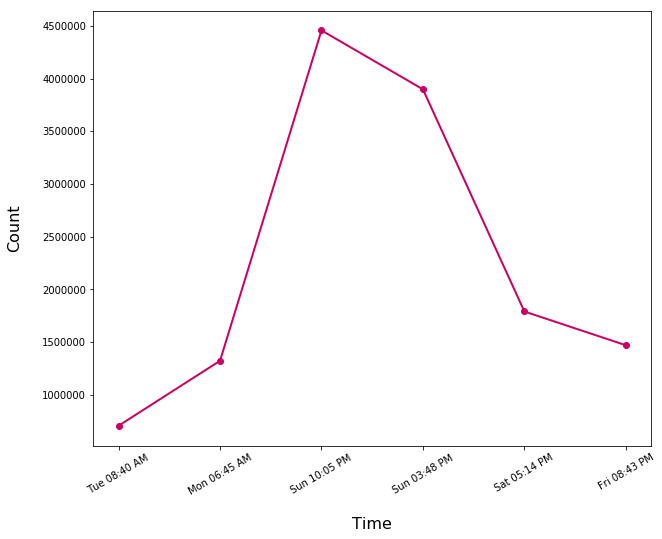

In [2]:
### username = %store -r username
# password = %store -r password

import getpass
key = getpass.getpass('Password :: ')

bot = InstagramBot('hackmachina', key)
bot.signIn()
bot.disableNotifications()
bot.followWithUsername('michiko_shiba')
bot.unfollowWithUsername('therock')
bot.getUserFollowers('tame__impala', 50)
bot.getPictureData("billieeilish")
bot.getPictureData("michiko_shiba")
bot.getPictureData("therock")


Some things I did on my own was implemented the disableNotifications() and getPicturesData(). I selected the pictures on the profile page on my own and spent a long time trying to figure out how to get more pictures with Instagam's infinite scrolling though I could not get it to work in time. In getPicturesData I included a link that helped me get the JSON object and load the source page but I manually went through the JSON object to retrieve attributes that I wanted which was not covered in the link. I now realize I could have used python get() function which would have made it easier but you live and learn. It was challenging going through the JSON object because sometimes the object keys would disappear or change names for different accounts. Through trial and error, I added logic to consider all the differences or case edges I noticed. I implemented the pandas dataFrame with the objects I extracted and adjusted somee variable formats like for the timestamp. I then graphed the time vs post likes to see which time has the highest number of "likes". In my presentation my getUserFollowers kept scrolling on the main page but that's because I added a newline statement for style formatting in the console that kept being hit in a for loop. Once I took this out, you can see the followers printed in the console and the function work properly. I also experimented with different accounts other than 'therock' used in the tutorial. I have included the file instagram-copy which does not run, it is just split up for the tutorial. This file is the final and running code. Thank you.